# AEVB for VAE

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%config InlineBackend.figure_formats = ['png']
from scipy.signal import savgol_filter

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as d
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
d

<module 'torch.distributions' from '/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/torch/distributions/__init__.py'>

In [4]:
from sklearn.manifold import TSNE

In [5]:
import time
from tqdm import tqdm
from copy import deepcopy
import os
import pickle

In [6]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
# def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
#     subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

## Data

In [7]:
from keras.datasets.mnist import load_data

In [8]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256
x_train = x_train.reshape(-1, 28*28)

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256
x_test = x_test.reshape(-1, 28*28)

train_ds = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(np.eye(10)[y_train]).float())
train_dl = DataLoader(train_ds, batch_size=100)

test_ds = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(np.eye(10)[y_test]).float())
test_dl = DataLoader(test_ds, batch_size=1000)

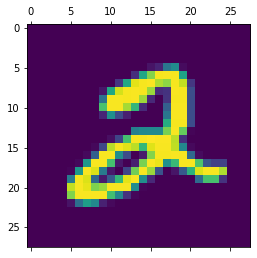

In [9]:
plt.matshow(x_train[5].reshape(28, 28))

## Modules

In [10]:
Ind = d.Independent
CB = d.ContinuousBernoulli
Normal = d.Normal

In [11]:
class p_z_given_y_class(nn.Module):

    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.mus = nn.Linear(y_dim, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(y_dim, z_dim),
            nn.Softplus()
        )

    def forward(self, ys):
        return Ind(Normal(self.mus(ys), self.sigmas(ys)), 1)

In [12]:
class p_x_given_y_z_class(nn.Module):
    """
    p_x_given_z
    Take in latent vectors, output distribution over images
    """

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.lambdas = nn.Sequential(
            
            nn.Linear(y_dim + z_dim, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, x_dim),
            nn.Sigmoid()  # -> (0, 1)
        )

    def forward(self, ys, zs):
        return Ind(CB(self.lambdas(torch.cat([ys, zs], dim=1))), 1)

In [13]:
class q_z_given_x_y_class(nn.Module):
    """
    q_z_given_x
    Take in image, output distribution over latent vectors
    """

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            
            nn.Linear(x_dim + y_dim, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
        
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()  # -> (0, infinity)
        )

    def forward(self, xs, ys):
        temp = self.shared(torch.cat([xs, ys], dim=1))
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

## AEVB

In [37]:
class ImageDLVM(nn.Module):
    """
    This is the VAE class. I personally don't like the name VAE and I prefer DLVM, which stands for Deep Latent Variable Model. This name seems to be
    better connected with theory, e.g., latent variable models, expectation maximization and so on.
    """

    def __init__(self, x_dim, y_dim, z_dim, lr=3e-4):
        
        super().__init__()

        # hyper-parameters
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.lr = lr

        # describes the generative process
        self.p_z_given_y = p_z_given_y_class(y_dim=y_dim, z_dim=z_dim)
        self.p_x_given_z_y = p_x_given_y_z_class(x_dim=x_dim, y_dim=y_dim, z_dim=z_dim)

        # required for approximate posterior inference
        self.q_z_given_x_y = q_z_given_x_y_class(z_dim=z_dim, x_dim=x_dim, y_dim=y_dim)

        # gradient-based optimizers
        self.opt = optim.Adam(self.parameters(), lr=lr)

    def step(self, xs, ys, evaluate=False):
        if evaluate:
            self.eval()
        else:
            self.train()
        posterior_over_zs = self.q_z_given_x_y(xs, ys)
        prior_over_zs = self.p_z_given_y(ys)
        # kl-divergence
        kl = d.kl.kl_divergence(posterior_over_zs, prior_over_zs).mean()
        # reconstruction
        zs = posterior_over_zs.rsample()  # sample using the re-parametrization trick
        #kl = ((posterior_over_zs.log_prob(zs) - self.p_z.log_prob(zs))).mean()
        rec = self.p_x_given_z_y(ys, zs).log_prob(xs).mean()
        # elbo (estimated using one sample per posterior)
        elbo = - kl + rec
        # backpropagation and gradient step
        loss = - elbo
        if not evaluate:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return {
            "kl": float(kl),  # this is at least 0; the smaller the better
            "rec": float(rec),  # the larger the better
            "elbo": float(elbo)  # the larger the better
        }

    def encode(self, xs, ys):
        with torch.no_grad():
            return self.q_z_given_x_y(xs, ys).mean

    def save(self, save_dir):
        torch.save(self.p_z_given_y.state_dict(), os.path.join(save_dir, "p_z_given_y.pth"))
        torch.save(self.p_x_given_z_y.state_dict(), os.path.join(save_dir, "p_x_given_z_y.pth"))
        torch.save(self.q_z_given_x_y.state_dict(), os.path.join(save_dir, "q_z_given_x_y.pth"))

    def load(self, save_dir):
        self.p_z_given_y.load_state_dict(
            torch.load(os.path.join(save_dir, "p_z_given_y.pth"), map_location=torch.device("cpu"))
        )
        self.p_x_given_z_y.load_state_dict(
            torch.load(os.path.join(save_dir, "p_x_given_z_y.pth"), map_location=torch.device("cpu"))
        )
        self.q_z_given_x_y.load_state_dict(
            torch.load(os.path.join(save_dir, "q_z_given_x_y.pth"), map_location=torch.device("cpu"))
        )

## Training

In [38]:
from tqdm import tqdm

In [39]:
model = ImageDLVM(z_dim=20, x_dim=28*28, y_dim=10)

test_elbos = []

for epoch in range(100):
    print(epoch)
    for (xb, yb) in tqdm(train_dl):
        stats_dict = model.step(xb, yb)
    test_elbo = np.mean([model.step(xb, yb, evaluate=True)["elbo"] for (xb, yb) in test_dl])
    print(test_elbo)
    test_elbos.append(test_elbo)

0


100%|███████████████████████████████████████████| 600/600 [00:08<00:00, 73.14it/s]


1467.4289794921874
1


100%|███████████████████████████████████████████| 600/600 [00:08<00:00, 69.78it/s]


1602.426025390625
2


100%|███████████████████████████████████████████| 600/600 [00:09<00:00, 64.32it/s]


1658.897607421875
3


100%|███████████████████████████████████████████| 600/600 [00:09<00:00, 60.47it/s]


1694.2338745117188
4


100%|███████████████████████████████████████████| 600/600 [00:09<00:00, 64.85it/s]


1716.3199096679687
5


100%|███████████████████████████████████████████| 600/600 [00:09<00:00, 63.96it/s]


1734.836376953125
6


100%|███████████████████████████████████████████| 600/600 [00:10<00:00, 54.73it/s]


1748.6346435546875
7


100%|███████████████████████████████████████████| 600/600 [00:18<00:00, 32.91it/s]


1757.8502807617188
8


 40%|█████████████████▏                         | 240/600 [00:06<00:09, 37.37it/s]


KeyboardInterrupt: 

In [40]:
model.save(".")
with open("test_elbos", "wb") as fp:
    pickle.dump(test_elbos, fp)

In [41]:
model.load(".")

In [42]:
def generate_from_y(self, y, n, mode):
    self.eval()
    with torch.no_grad():
        ys = torch.eye(10)[y].unsqueeze(0).repeat(n, 1)
        zs = self.p_z_given_y(ys).sample()
        if mode == "mean":
            return self.p_x_given_z_y(ys, zs).mean
        elif mode == "sample":
            return self.p_x_given_z_y(ys, zs).sample()
        elif mode == "param":
            return self.p_x_given_z_y.lambdas(torch.cat([ys, zs], dim=1))
        else:
            raise ValueError(f"{mode} is not a valid mode for generate.")

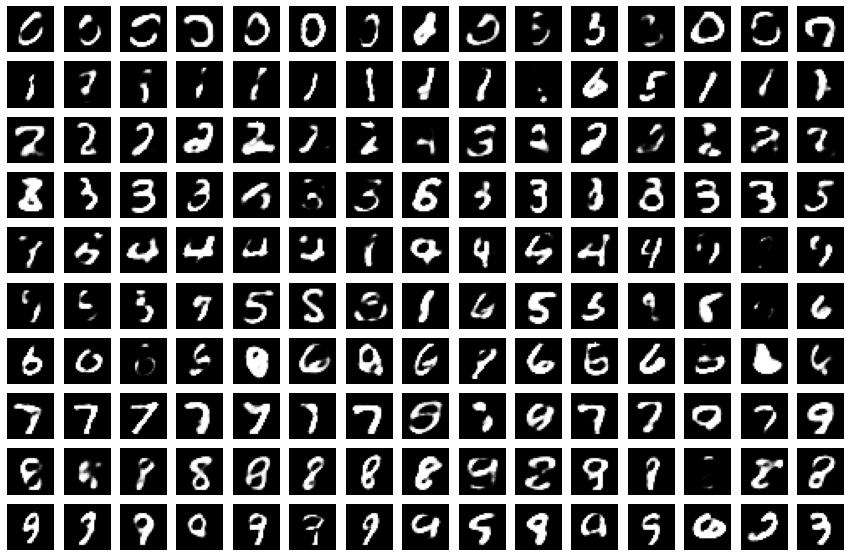

In [43]:
torch.manual_seed(12)
plt.figure(figsize=(15, 10))
for row_index, cluster_index in enumerate(range(10)):
    gens = generate_from_y(model, n=15, y=cluster_index, mode="param")
    for col_index in range(15):
        plt.subplot(10, 15, row_index * 15 + col_index + 1)
        plt.imshow(gens[col_index].reshape(28, 28), cmap="gray")
        plt.axis('off')
plt.savefig("mnist_gens_conditional_param.pdf", bbox_inches='tight',pad_inches = 0)

## ELBO plot

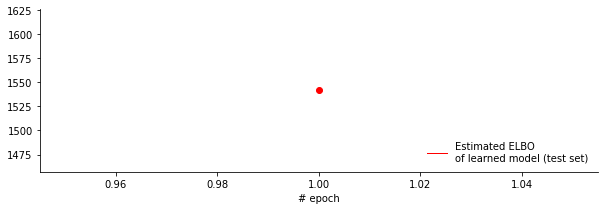

In [31]:
plt.figure(figsize=(10, 3))

# plt.plot(elbos, linewidth=1, color="red", alpha=0.3)
plt.plot(range(1, len(test_elbos)+1), test_elbos, linewidth=1, color="red", label="Estimated ELBO\nof learned model (test set)")
plt.scatter(range(1, len(test_elbos)+1), test_elbos, color="red")
plt.xlabel("# epoch")
# plt.xticks(np.arange(1, 16))
# plt.xlim(1, 15)

plt.legend(loc="lower right", frameon=False)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.savefig("learning_curve.pdf", bbox_inches='tight', pad_inches = 0)